In [36]:
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(BASE_DIR)

In [37]:
from src.features import (
    parse_skills_column,
    rebuild_skills_list,
    build_skill_profiles,
    clean_skill,
    plot_skill_radar
)



In [38]:
from pathlib import Path
import pandas as pd


# proje kök dizini (notebooks klasöründen bir üst klasör)
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

csv_path = PROCESSED_DATA_DIR / "jobs_clean.csv"
df = pd.read_csv(csv_path)

df.head()


,company,employmenttype_jobstatus,jobdescription,joblocation_address,jobtitle,postdate,skills,jobdescription_clean,skills_clean
0,"Digital Intelligence Systems, LLC","C2H Corp-To-Corp, C2H Independent, C2H W2, 3 M...",Looking for Selenium engineers...must have sol...,"Atlanta, GA",AUTOMATION TEST ENGINEER,1 hour ago,SEE BELOW,looking for selenium engineers must have solid...,NaN
1,University of Chicago/IT Services,Full Time,The University of Chicago has a rapidly growin...,"Chicago, IL",Information Security Engineer,1 week ago,"linux/unix, network monitoring, incident respo...",the university of chicago has a rapidly growin...,"['linux', 'unix', 'network monitoring', 'incid..."
2,"Galaxy Systems, Inc.",Full Time,"GalaxE.SolutionsEvery day, our solutions affec...","Schaumburg, IL",Business Solutions Architect,2 weeks ago,"Enterprise Solutions Architecture, business in...",galaxe solutionsevery day our solutions affect...,"['enterprise solutions architecture', 'busines..."
3,TransTech LLC,Full Time,Java DeveloperFull-time/direct-hireBolingbrook...,"Bolingbrook, IL","Java Developer (mid level)- FT- GREAT culture,...",2 weeks ago,Please see job description,java developerfull time direct hirebolingbrook...,NaN
4,Matrix Resources,Full Time,Midtown based high tech firm has an immediate ...,"Atlanta, GA",DevOps Engineer,48 minutes ago,"Configuration Management, Developer, Linux, Ma...",midtown based high tech firm has an immediate ...,"['configuration management', 'developer', 'lin..."


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

X = vectorizer.fit_transform(df["jobdescription_clean"])

k = 10
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

df["cluster"] = clusters
df["cluster"].value_counts()


cluster
4    6056
7    4037
1    3065
2    2501
5    2327
3    1969
0     788
8     539
6     416
9     302
Name: count, dtype: int64

In [40]:
import ast

# skills_clean string -> list dönüşümü
df_skills = df.dropna(subset=["skills_clean"]).copy()

df_skills["skills_clean"] = df_skills["skills_clean"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_skills["skills_clean"].head(5)


1    [linux, unix, network monitoring, incident res...
2    [enterprise solutions architecture, business i...
4    [configuration management, developer, linux, m...
5               [fico, ar, ap, asset management, haha]
6    [cisco, dns, http, networking, network enginee...
Name: skills_clean, dtype: object

In [41]:
import re
from typing import List, Union

def clean_skill(skill: str) -> Union[str, None]:
    """
    Tek bir skill string'ini normalize eder.
    """
    skill = skill.lower().strip()
    
    remove_list = [
        "see below",
        "please see job description",
        "haha",
    ]
    for bad in remove_list:
        if bad in skill:
            return None

    # sadece harf, rakam, +, #, . ve boşluk
    skill = re.sub(r"[^a-z0-9#+. ]", "", skill)
    skill = skill.strip(" .,+-")

    if len(skill) == 0:
        return None
    
    return skill


def rebuild_skills_list(skill_list: Union[List[str], None]) -> Union[List[str], None]:
    """
    Bir satırdaki skill listesi için temizlenmiş skill listesi döner.
    """
    if not isinstance(skill_list, list):
        return None
    
    cleaned: List[str] = []
    for skill in skill_list:
        cleaned_skill = clean_skill(skill)
        if cleaned_skill:
            cleaned.append(cleaned_skill)
    
    return cleaned if cleaned else None


In [42]:
df_skills["skills_filtered"] = df_skills["skills_clean"].apply(rebuild_skills_list)

df_skills[["skills_clean", "skills_filtered"]].head(10)


,skills_clean,skills_filtered
1,"[linux, unix, network monitoring, incident res...","[linux, unix, network monitoring, incident res..."
2,"[enterprise solutions architecture, business i...","[enterprise solutions architecture, business i..."
4,"[configuration management, developer, linux, m...","[configuration management, developer, linux, m..."
5,"[fico, ar, ap, asset management, haha]","[fico, ar, ap, asset management]"
6,"[cisco, dns, http, networking, network enginee...","[cisco, dns, http, networking, network enginee..."
7,"[.net, c#, mvc, restful web services, http, aw...","[net, c#, mvc, restful web services, http, aws..."
8,"[c++, developer, development, javascript, user...","[c, developer, development, javascript, user i..."
10,[openstack],[openstack]
11,"[unix, iam, scripting knowledge, oim, windows,...","[unix, iam, scripting knowledge, oim, windows,..."
12,"[java, oss]","[java, oss]"


In [43]:
from collections import Counter

cluster_skill_profiles = {}

for c in sorted(df_skills["cluster"].unique()):
    skills = []
    for row in df_skills[df_skills["cluster"] == c]["skills_filtered"]:
        if isinstance(row, list):
            skills.extend(row)
    cluster_skill_profiles[c] = Counter(skills).most_common(20)

for c, skills in cluster_skill_profiles.items():
    print(f"\nCLUSTER {c}")
    for skill, count in skills[:10]:
        print(f"{skill} → {count}")



CLUSTER 0
security → 227
cissp → 141
management → 77
development → 53
analysis → 51
linux → 50
unix → 39
siem → 39
ids → 39
python → 39

CLUSTER 1
javascript → 758
java → 704
css → 460
html → 455
sql → 444
c# → 437
jquery → 341
net → 316
asp.net → 273
j2ee → 271

CLUSTER 2
windows → 332
cisco → 313
vmware → 293
linux → 263
security → 218
active directory → 202
management → 192
hardware → 174
networking → 162
wan → 162

CLUSTER 3
sql → 502
hadoop → 178
etl → 175
java → 163
python → 149
oracle → 139
development → 127
business intelligence → 120
management → 110
analysis → 103

CLUSTER 4
sql → 333
java → 332
development → 217
management → 192
linux → 163
javascript → 158
sales → 153
project → 151
oracle → 136
security → 133

CLUSTER 5
java → 630
linux → 385
python → 371
development → 343
javascript → 279
aws → 247
agile → 211
management → 210
c → 205
programming → 188

CLUSTER 6
javascript → 179
sql → 107
python → 83
java → 79
css → 76
c# → 72
c → 69
html → 66
mysql → 63
linux → 62

CLUS

In [44]:
def clean_text_for_cv(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9#+.\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [45]:
import numpy as np

def analyze_cv(cv_text: str, top_n_skills: int = 15):
    # 1) CV'yi temizle
    cv_clean = clean_text_for_cv(cv_text)
    
    # 2) TF-IDF vektörüne çevir
    cv_vec = vectorizer.transform([cv_clean])
    
    # 3) En yakın cluster'ı bul
    cluster_id = kmeans.predict(cv_vec)[0]
    
    # 4) Bu cluster'daki ilanların jobtitle dağılımı
    titles = df[df["cluster"] == cluster_id]["jobtitle"]
    top_titles = titles.value_counts().head(5)
    
    # 5) Bu cluster'ın en sık görülen skill'leri
    cluster_skills = [s for s, c in cluster_skill_profiles[cluster_id][:top_n_skills]]
    
    # 6) CV'de geçen skill'leri tespit et
    present_skills = [s for s in cluster_skills if s in cv_clean]
    missing_skills = [s for s in cluster_skills if s not in present_skills]
    
    # 7) Skill ağırlıkları (cluster içi frekansa göre)
    weights = skill_weights[cluster_id]
    
    present_score = sum(weights.get(skill, 0) for skill in present_skills)
    total_score = sum(weights.get(skill, 0) for skill in cluster_skills)
    match_score = (present_score / total_score) if total_score > 0 else 0.0
    gap_score = 1 - match_score
    
    return {
        "cluster_id": int(cluster_id),
        "top_titles": top_titles,
        "cluster_top_skills": cluster_skills,
        "present_skills": present_skills,
        "missing_skills": missing_skills,
        "match_score": float(match_score),
        "gap_score": float(gap_score),
    }


In [46]:
sample_cv = """
I am a software engineer with 3 years of experience in backend development.
I work mostly with Java, Spring Boot, REST APIs and relational databases (SQL).
I use Git, Docker and basic AWS services. I have experience with microservices,
unit testing and agile methodologies.
"""


In [47]:
# Cluster bazlı skill frekanslarını ağırlığa çeviriyoruz
skill_weights = {}

for c, skills in cluster_skill_profiles.items():
    if skills:
        max_freq = max(freq for skill, freq in skills)
    else:
        max_freq = 1
    
    skill_weights[c] = {
        skill: freq / max_freq for skill, freq in skills
    }


In [48]:
result = analyze_cv(sample_cv, top_n_skills=15)

print("Predicted cluster:", result["cluster_id"])
print("\nMost common job titles in this cluster:")
print(result["top_titles"])

print("\nRole match score (%):", round(result["match_score"] * 100, 1))
print("Skill gap score (%):", round(result["gap_score"] * 100, 1))

print("\nExpected skills in this role:")
print(result["cluster_top_skills"])

print("\nSkills found in CV:")
print(result["present_skills"])

print("\nMissing skills for this role:")
print(result["missing_skills"])


Predicted cluster: 5

Most common job titles in this cluster:
jobtitle
DevOps Engineer                  50
Software Engineer                39
Senior Software Engineer         31
Software Development Engineer    27
Java Developer                   25
Name: count, dtype: int64

Role match score (%): 50.7
Skill gap score (%): 49.3

Expected skills in this role:
['java', 'linux', 'python', 'development', 'javascript', 'aws', 'agile', 'management', 'c', 'programming', 'sql', 'mysql', 'c#', 'devops', 'testing']

Skills found in CV:
['java', 'development', 'aws', 'agile', 'c', 'sql', 'testing']

Missing skills for this role:
['linux', 'python', 'javascript', 'management', 'programming', 'mysql', 'c#', 'devops']


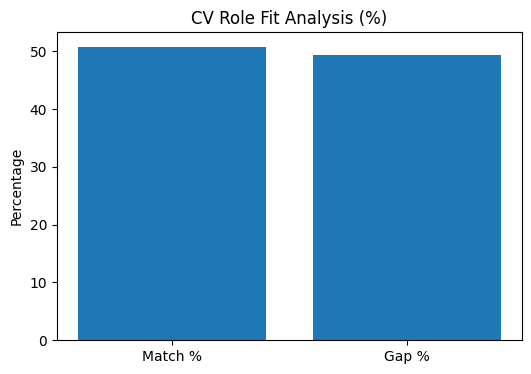

In [49]:
import matplotlib.pyplot as plt

labels = ["Match %", "Gap %"]
values = [
    result["match_score"] * 100,
    result["gap_score"] * 100
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.title("CV Role Fit Analysis (%)")
plt.ylabel("Percentage")
plt.show()


In [50]:
cluster_id = result["cluster_id"]
cluster_skills = result["cluster_top_skills"]
weights = skill_weights[cluster_id]

skill_labels = cluster_skills
skill_values = [1 if s in result["present_skills"] else 0 for s in cluster_skills]


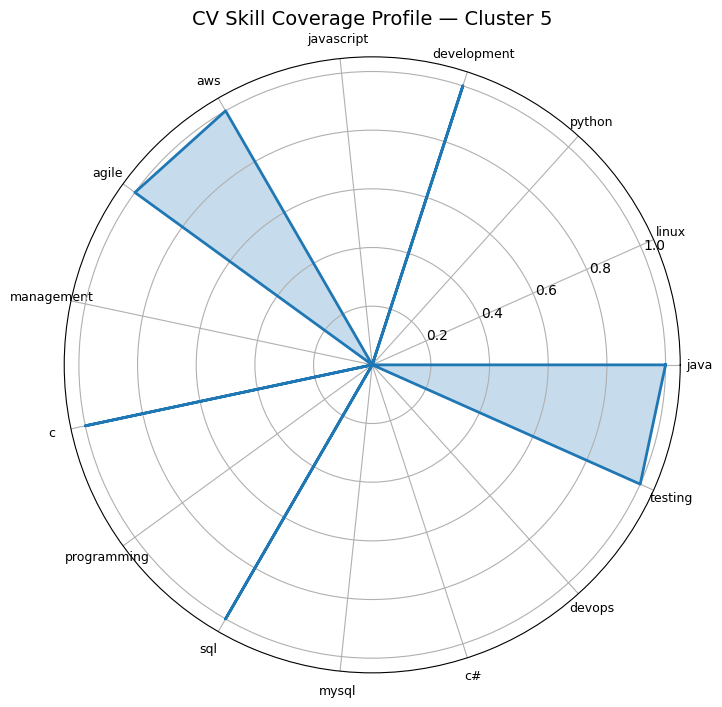

In [51]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.linspace(0, 2 * np.pi, len(skill_labels), endpoint=False).tolist()
skill_values += skill_values[:1]
angles += angles[:1]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

ax.fill(angles, skill_values, alpha=0.25)
ax.plot(angles, skill_values, linewidth=2, linestyle='solid')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(skill_labels, fontsize=9)

ax.set_title("CV Skill Coverage Profile — Cluster {}".format(cluster_id), size=14)
plt.show()


In [52]:
!pip install PyPDF2


In [53]:
import PyPDF2

def read_pdf_text(pdf_path):
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text


In [54]:
cv_text = read_pdf_text("EsraBerfinErtanCVEng.pdf")
result = analyze_cv(cv_text)


In [55]:
print("Predicted cluster:", result["cluster_id"])
print("\nRole match score (%):", round(result["match_score"] * 100, 1))
print("Skill gap score (%):", round(result["gap_score"] * 100, 1))

print("\nMost common titles for this role:")
print(result["top_titles"])

print("\nSkills found in CV:")
print(result["present_skills"])

print("\nMissing skills for this role:")
print(result["missing_skills"])


Predicted cluster: 5

Role match score (%): 46.8
Skill gap score (%): 53.2

Most common titles for this role:
jobtitle
DevOps Engineer                  50
Software Engineer                39
Senior Software Engineer         31
Software Development Engineer    27
Java Developer                   25
Name: count, dtype: int64

Skills found in CV:
['python', 'development', 'management', 'c', 'programming', 'sql', 'mysql', 'c#']

Missing skills for this role:
['java', 'linux', 'javascript', 'aws', 'agile', 'devops', 'testing']


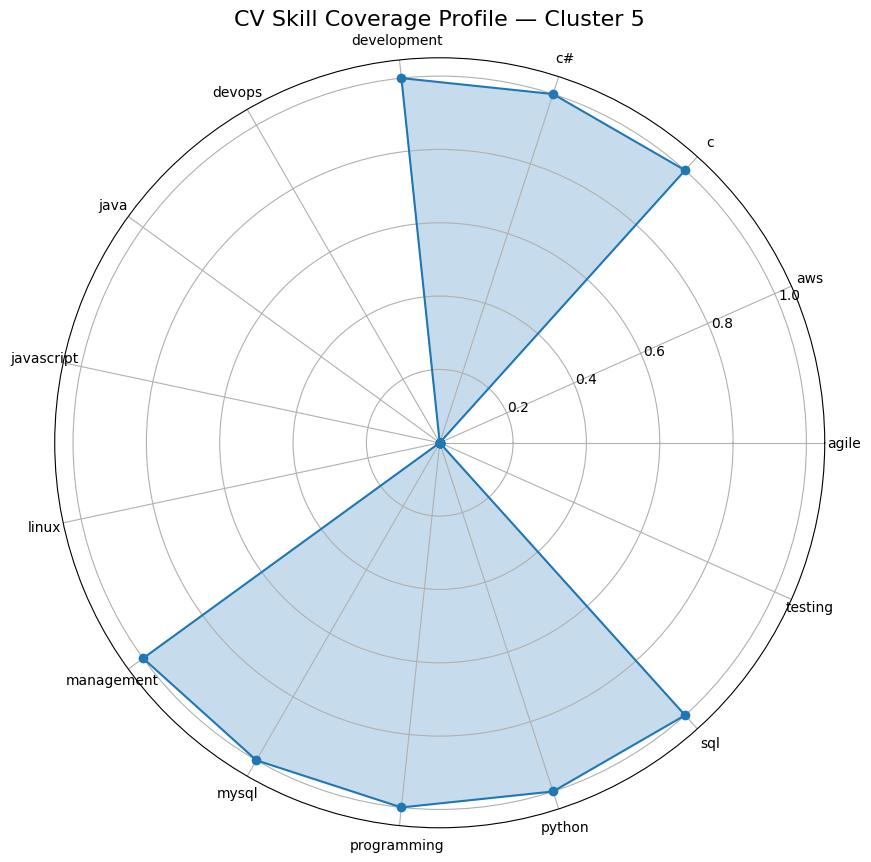

In [57]:
plot_skill_radar(
    expected=result["cluster_top_skills"],
    present=result["present_skills"],
    cluster_id=result["cluster_id"]
)
